In [1]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt

# 1. Twitch API data

The URL `https://wind-bow.glitch.me/twitch-api/channels/{CHANNEL_NAME}` is an API from twitch to get data from twitch channels.

Get the data from the following channels:

```
["ESL_SC2", "OgamingSC2", "cretetion", "freecodecamp", 
    "storbeck", "habathcx", "RobotCaleb", "noobs2ninjas",
    "ninja", "shroud", "Dakotaz", "esltv_cs", "pokimane", 
    "tsm_bjergsen", "boxbox", "wtcn", "a_seagull",
    "kinggothalion", "amazhs", "jahrein", "thenadeshot", 
    "sivhd", "kingrichard"]
```

To make into a dataframe that looks like this:

![](twitch.png)

In [2]:
ch = ["ESL_SC2", "OgamingSC2", "cretetion", "freecodecamp", 
    "storbeck", "habathcx", "RobotCaleb", "noobs2ninjas",
    "ninja", "shroud", "Dakotaz", "esltv_cs", "pokimane", 
    "tsm_bjergsen", "boxbox", "wtcn", "a_seagull",
    "kinggothalion", "amazhs", "jahrein", "thenadeshot", 
    "sivhd", "kingrichard"]

In [3]:
appended_data = []
for c in ch:
    r = requests.get(f"https://wind-bow.glitch.me/twitch-api/channels/{c}")
    # print(r.status_code)
    if r.status_code == 200:
        #print(c)
        df = pd.DataFrame.from_dict(json.loads(r.content))
        appended_data.append(df)

appended_data = pd.concat(appended_data)
appended_data = appended_data.loc['self',['_id','display_name','status','followers','views']]
appended_data.reset_index(inplace=True)
appended_data.drop(columns='index')

,_id,display_name,status,followers,views
0,30220059,ESL_SC2,RERUN: StarCraft 2 - Terminator vs. Parting (P...,135394,60991791
1,71852806,OgamingSC2,UnderDogs - Rediffusion - Qualifier.,40895,20694507
2,90401618,cretetion,It's a Divison kind of Day,908,11631
3,79776140,FreeCodeCamp,Greg working on Electron-Vue boilerplate w/ Ak...,10122,163747
4,86238744,storbeck,None,10,1019
5,6726509,Habathcx,Massively Effective,14,764
6,54925078,RobotCaleb,Code wrangling,20,4602
7,82534701,noobs2ninjas,Building a new hackintosh for #programming and...,835,48102


# 2. App Store Reviews

The Apple app store has a `GET` API to get reviews on apps. The URL is:

```
https://itunes.apple.com/{COUNTRY_CODE}/rss/customerreviews/id={APP_ID_HERE}/page={PAGE_NUMBER}/sortby=mostrecent/json
```

Note that you need to provide:

- The country code (eg. `'us'`, `'gb'`, `'ca'`, `'au'`) 

- The app ID. This can be found in the web page for the app right after `id`. For instance, Candy Crush's US webpage is:

`https://apps.apple.com/us/app/candy-crush-saga/id553834731`

So here the ID would be `553834731`.

- The "Page Number". The request responds with multiple pages of data, but sends them one at a time. So you can cycle through the data pages for any app on any country.

### 2.1 English app reviews

Get all english reviews you can for Candy Crush, Tinder, the Facebook app and Twitter (you have to get them from all the english-speaking countries you can think of!).

### 2.2 Best version

For each app, get the version that is the best rated.

Make a visualization of the ratings per versions per app to show this.

### 2.3 Top words

Which word for each app is most common in the 5 star and in the 1-star review's titles?

Note: `df.title.str.get_dummies()` is your friend

Note: This might create a lot of data! Try to break down your analysis in chunks if it doesn't work.

In [4]:
#2-1
final = []
co = ['us', 'gb', 'ca', 'au']
apps = [553834731,547702041,284882215,333903271]
pp = 1
for c in co:
    pp = 1
    for app in apps:
        try:
            #print(f'page number: {pp}')
            r = requests.get(f"https://itunes.apple.com/{c}/rss/customerreviews/id={app}/page={pp}/sortby=mostrecent/json")
            cc = json.loads(r.content)
            if r.status_code == 200:
                for i in cc['feed']['entry']:
                    #print(i['content']['label'])
                    final.append({app,i['content']['label']})
                    #print(i['content']['label'])

            pp += 1
        except:
            print('error')

df = pd.DataFrame(final)
df.columns=['review','app_id']
df

,review,app_id
0,553834731,I am now on level 3359it’s impossible with the...
1,Every time I make a purchase it robs me and th...,553834731
2,Unable to open App for the past week,553834731
3,553834731,Amazing
4,This game has come a long way and I love the m...,553834731
...,...,...
795,"Not happy with censorship of conservatives, Ch...",333903271
796,Allows dictators and Human rights abusers but ...,333903271
797,Twitter is where the light is shined on RWNJ a...,333903271
798,Taking away freedom of speech,333903271


In [5]:
#2-2
ap = []
co = ['us', 'gb', 'ca', 'au']
apps = [553834731,547702041,284882215,333903271]
pp = 1
for c in co:
    pp = 1
    for app in apps:
        try:
            #print(f'page number: {pp}')
            r = requests.get(f"https://itunes.apple.com/{c}/rss/customerreviews/id={app}/page={pp}/sortby=mostrecent/json")
            cc = json.loads(r.content)
            if r.status_code == 200:
                for i in cc['feed']['entry']:
                    row=[app,i['im:version']['label'],i['im:rating']['label']]
                    ap.append(row)
            pp += 1
        except:
            print('error')

df = pd.DataFrame(ap)
df.columns=['app_id','version','rating']

In [6]:
df.rating = df.rating.astype(int)

In [7]:
df

,app_id,version,rating
0,553834731,1.196.0.1,1
1,553834731,1.196.0.1,2
2,553834731,1.196.0.1,4
3,553834731,1.196.0.1,5
4,553834731,1.196.0.1,4
...,...,...,...
795,333903271,8.48,1
796,333903271,8.48,1
797,333903271,8.48,5
798,333903271,8.48,1


In [8]:
df1= df.groupby(['app_id' , 'version'],as_index=False).agg({'rating':'mean'}).sort_values('rating',ascending=False)

#as_index=False
# df.groupby('version').agg({'rating': 'mean'})

In [9]:
idx=df1.groupby(['app_id'])['rating'].transform(max)==df1['rating']
df1[idx]
# 284882215 306 1.42
# 333903271 7.51.5 1

,app_id,version,rating
3,333903271,8.50,4.000000
15,553834731,1.196.0.1,3.041237
7,547702041,11.31.0,1.651163
1,284882215,306.0,1.275862


array([[<AxesSubplot:title={'center':'rating'}>]], dtype=object)

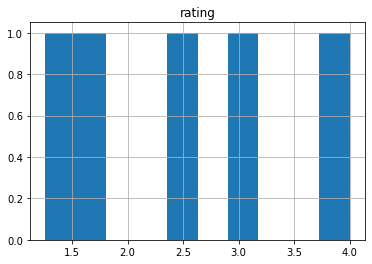

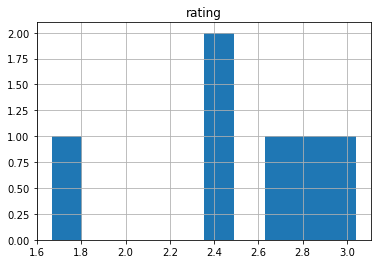

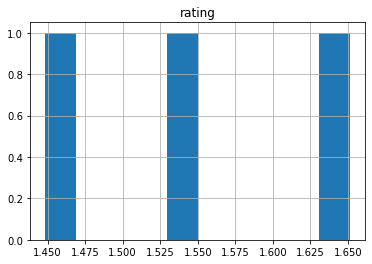

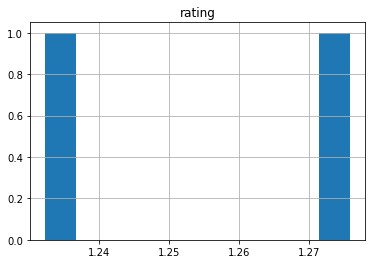

In [10]:
df2 =  df1.loc[df1.app_id==333903271]
df2[['version','rating']].hist()

df2 =  df1.loc[df1.app_id==553834731]
df2[['version','rating']].hist()

df2 =  df1.loc[df1.app_id==547702041]
df2[['version','rating']].hist()

df2 =  df1.loc[df1.app_id==284882215]
df2[['version','rating']].hist()


In [110]:
# df.title.str.get_dummies(' ')
#  df1.sum()

rating    33.419039
dtype: float64

In [17]:
# 2-3
ap1 = []
ap5 = []
co = ['us', 'gb', 'ca', 'au']
apps = [553834731,547702041,284882215,333903271]
pp = 1
for c in co:
    pp = 1
    for app in apps:
        try:
            #print(f'page number: {pp}')
            r = requests.get(f"https://itunes.apple.com/{c}/rss/customerreviews/id={app}/page={pp}/sortby=mostrecent/json")
            cc = json.loads(r.content)
            if r.status_code == 200:
                for i in cc['feed']['entry']:
                    if i['im:rating']['label'] == '5':
                        fivestars=[app,i['title']['label']]
                        ap5.append(fivestars)
                    if i['im:rating']['label'] == '1' : 
                        onestar=[app,i['title']['label']]
                        ap1.append(onestar)    
            pp += 1
        except:
            print('error')

In [50]:
df1 = pd.DataFrame(ap1)
df5 = pd.DataFrame(ap5)
df1.columns=['app_id','title']
df5.columns=['app_id','title']

In [62]:
df1 = df1.join(df1.title.str.get_dummies(' '))
df1.drop('title',axis=1, inplace=True)

In [75]:
print('Candy Crush: the most common word is:',df1.loc[df1.app_id==553834731].sum().sort_values(ascending=False)[1:2] ) 
print('Tinder: the most common word is:',df1.loc[df1.app_id==547702041].sum().sort_values(ascending=False)[1:2])
print('Facebook: the most common word is:',df1.loc[df1.app_id==284882215].sum().sort_values(ascending=False)[1:2])
print('Twitter: the most common word is:',df1.loc[df1.app_id==333903271].sum().sort_values(ascending=False)[1:2])


Candy Crush: the most common word is: Candy    8
dtype: int64
Tinder: the most common word is: for    18
dtype: int64
Facebook: the most common word is: Facebook    18
dtype: int64
Twitter: the most common word is: accounts    15
dtype: int64


In [76]:
df5 = df5.join(df5.title.str.get_dummies(' '))
df5.drop('title',axis=1, inplace=True)
print('Candy Crush: the most common word is:',df5.loc[df5.app_id==553834731].sum().sort_values(ascending=False)[1:2] ) 
print('Tinder: the most common word is:',df5.loc[df5.app_id==547702041].sum().sort_values(ascending=False)[1:2])
print('Facebook: the most common word is:',df5.loc[df5.app_id==284882215].sum().sort_values(ascending=False)[1:2])
print('Twitter: the most common word is:',df5.loc[df5.app_id==333903271].sum().sort_values(ascending=False)[1:2])

Candy Crush: the most common word is: game    8
dtype: int64
Tinder: the most common word is: Tinder    2
dtype: int64
Facebook: the most common word is: of    2
dtype: int64
Twitter: the most common word is: Twitter    5
dtype: int64


In [ ]:
# https://itunes.apple.com/{COUNTRY_CODE}/rss/customerreviews/id={APP_ID_HERE}/page={PAGE_NUMBER}/sortby=mostrecent/json

In [4]:
# r = requests.get(f"https://itunes.apple.com/us/rss/customerreviews/id=553834731/page=2/sortby=mostrecent/json")

# 3 (STRETCH) IMDB scraping

IMDB has structured web pages. We can exploit this to scrape movie data.

Usinf the following URL:

`https://www.imdb.com/search/title/?groups=top_1000&start={PAGE_NUMBER}&ref_=adv_nxt`

With the following headers in your `GET` request: `{"Accept-Language": "en-US,en;q=0.5"}`

You can generate a dataframe like this one by cycling over the page numbers in the URL requested:

![](IMDB.png)

Note that the following  page attribues will be of interest:

- `div` with a class of `lister-item mode-advanced`

- Various `span` objects within that `div` like `lister-item-year` and `runtime` and `metascore`